In [1]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import requests
from torchvision import transforms
import torch

import sys
#styleTransfer class directory
sys.path.insert(0, '../models')

from styleTransfer import styleTransfer

### Create the class variable
All of the neccesarry methods for style transfer are programmed inside

In [2]:
model = styleTransfer()

### Loading the images

In [3]:
def loadImg(img_path, maxSize=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > maxSize:
        size = maxSize
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    inTransform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = inTransform(image)[:3,:,:].unsqueeze(0)
    
    return image

#### Specify the pictures
Content variable holds the image on which the style will be applied

Style variable holds the image of which the style will be applied

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load in content and style image
content = loadImg('../data/images/portrait.jpg').to(device)
# Resize style to match content
style = loadImg('../data/images/HPcover.jpg', shape=content.shape[-2:]).to(device)

In [10]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def imConvert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

#### Display the two images

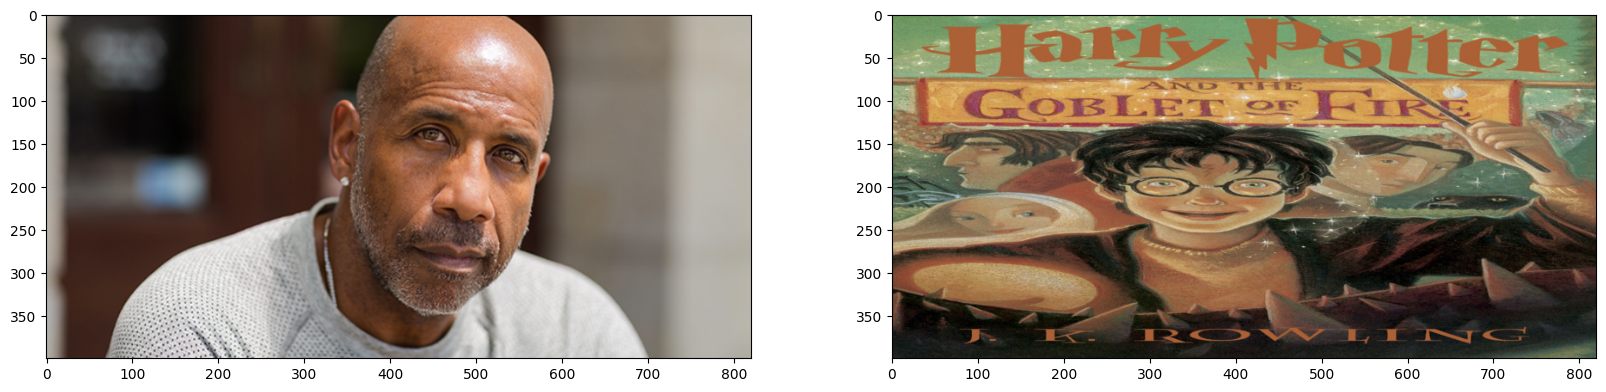

In [11]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(imConvert(content))
ax2.imshow(imConvert(style))

### Call the transfer method from the class and set some parameters

Variable layerWeights is used to weigh different layer errors, the higher the layer the more abstract the information it encodes

steps variable encodes the number of steps to make in the transfer of style. As it is an itterative process the more steps are made the more a "style" will be transfered.

In [13]:
#Set to True if you want to change the layerWeights or number of steps in the style transfer
use_custom =True

if use_custom:
    model.layerWeights = {'conv1_1': 1.0,
                         'conv2_1': 0.75,
                         'conv3_1': 0.3,
                         'conv4_1': 0.2,
                         'conv5_1': 0.2}
    
    model.steps = 5000
    model.showEvery = 1000
    
    #Use average pooling (default max pooling)
    model.changePooling(averagePool = True)

In [ ]:
#Runs the style transfer method for the specified number of steps and outputs the intermediate results every 400 steps.
target = model.transfer(content, style)

#### Display the final result side by side

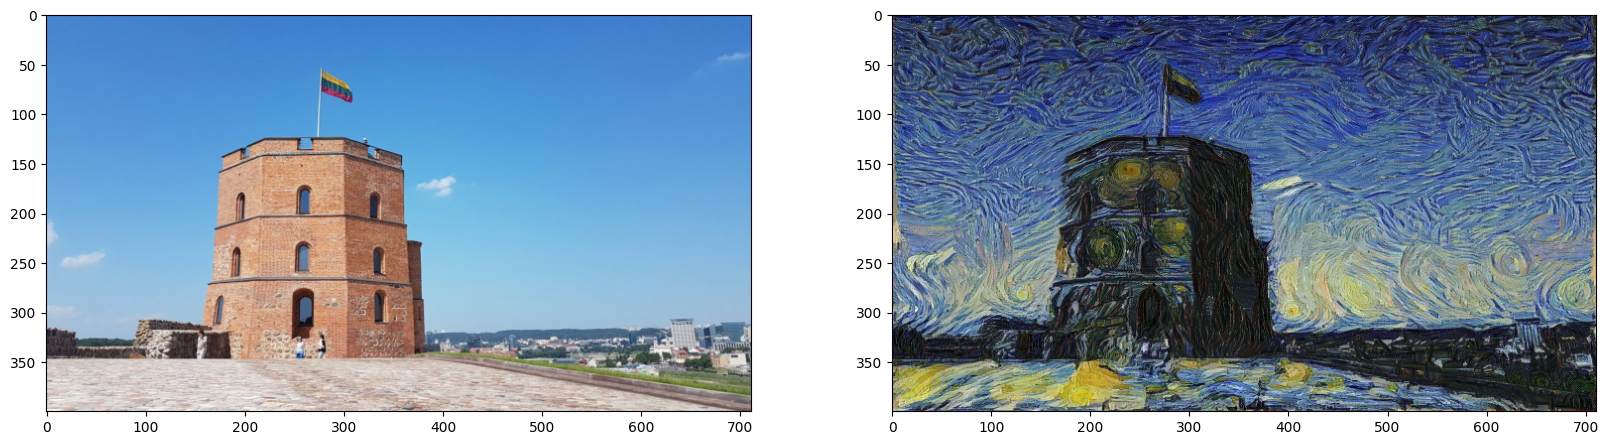

In [23]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(imConvert(content))
ax2.imshow(imConvert(target))

#### Save into local memory

To save set the to_save variable to True and specify the destination directory 

In [24]:
from matplotlib import pyplot

to_save = True

if to_save:
    pyplot.imsave('../data/images/gedPilis_averagepooling.jpg', imConvert(target))